In [4]:
# import useful libraries
import numpy as np # linear algebra
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob
import os

# import pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define paths
train_path = './intel-image-classification/seg_train/seg_train'
test_path = './intel-image-classification/seg_test/seg_test'
pred_path = './intel-image-classification/seg_pred/seg_pred'


In [5]:
transformer = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

train_loader = DataLoader(
    ImageFolder(train_path, transform=transformer),
    num_workers=8, batch_size=200, shuffle=True
)

test_loader = DataLoader(
    ImageFolder(test_path, transform=transformer),
    num_workers=8, batch_size=200, shuffle=True
)


In [6]:
resnet_model = models.resnet50(pretrained=True)

# freeze all parameters in ResNet so we won't have to retrain them
for param in resnet_model.parameters():
    param.requires_grad = False

# replace the last layer with another one that will be trainable
in_shape = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_shape, 6)

In [7]:
error = nn.CrossEntropyLoss()
opt = optim.Adam(resnet_model.parameters())

def train(model, train_loader, n_epochs=100):
    model = model.to(device)
    model.train()
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = error(out, y)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()        
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch: {epoch} \t Train Loss: {epoch_loss:.4g}')
            
train(resnet_model, train_loader)

epoch: 0 	 Train Loss: 44.65
epoch: 10 	 Train Loss: 15.88
epoch: 20 	 Train Loss: 13.58
epoch: 30 	 Train Loss: 12.72
epoch: 40 	 Train Loss: 11.32
epoch: 50 	 Train Loss: 10.67
epoch: 60 	 Train Loss: 9.816
epoch: 70 	 Train Loss: 9.466
epoch: 80 	 Train Loss: 8.922
epoch: 90 	 Train Loss: 8.664


In [8]:
def test(model, test_loader):
    model = model.to(device)
    model.eval()
    loss = 0
    for x, y in test_loader:
        with torch.no_grad():
            out = model(x.to(device)).cpu()
        loss += error(out, y)
        
    print(f'Test loss: {loss:.4g}')
    
test(resnet_model, test_loader)


Test loss: 4.598


In [10]:
torch.save(resnet_model,"resnet")

In [35]:
torch.save(resnet_model.state_dict(),"resnet_dict")

In [55]:
classes = train_loader.dataset.class_to_idx

def predict(model, path, sample_size=100):
    for file in glob(os.path.join(path, '*.jpg'))[:sample_size]:
        with Image.open(file) as f:
            img = transformer(f).unsqueeze(0)
            with torch.no_grad():
                out = model(img.to(device)).cpu().numpy()
            for key, value in classes.items():
                if value == np.argmax(out):
                    print(key)
                else :
                    print(out)
            plt.imshow(np.array(f))
            plt.show()
            

buildings
[[  9.239094  -15.836146   -9.302604   -6.849122   -3.5132303  -3.9725494]]
[[  9.239094  -15.836146   -9.302604   -6.849122   -3.5132303  -3.9725494]]
[[  9.239094  -15.836146   -9.302604   -6.849122   -3.5132303  -3.9725494]]
[[  9.239094  -15.836146   -9.302604   -6.849122   -3.5132303  -3.9725494]]
[[  9.239094  -15.836146   -9.302604   -6.849122   -3.5132303  -3.9725494]]


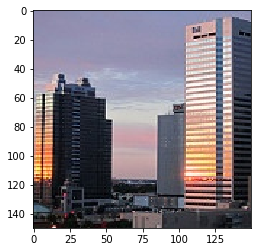

[[ -3.3712218  -7.3132334 -10.337731  -10.958098   -7.881851   10.667775 ]]
[[ -3.3712218  -7.3132334 -10.337731  -10.958098   -7.881851   10.667775 ]]
[[ -3.3712218  -7.3132334 -10.337731  -10.958098   -7.881851   10.667775 ]]
[[ -3.3712218  -7.3132334 -10.337731  -10.958098   -7.881851   10.667775 ]]
[[ -3.3712218  -7.3132334 -10.337731  -10.958098   -7.881851   10.667775 ]]
street


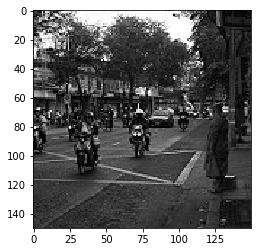

In [56]:
pred_path = './data'

predict(resnet_model, pred_path)